In [1]:
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
import numpy as np
import pandas as pd
from pandas_datareader import data
from datetime import date
import theano.tensor as tt
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import gc

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
# Disable INFO logging messages in Ipython Notebook
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
#Load data 
def load_csv(file):
    df = pd.read_csv(file, 
                    engine='c', 
                    low_memory=False,
                    )
    df = df.mask(df==0).fillna(method='backfill')
    df = df.fillna(method='ffill')
    df = df.fillna(method='backfill')
    return df

In [3]:
#Data Source explanation in https://auto-ml-app.herokuapp.com/
df = load_csv('gimnasio.csv')
df=df.iloc[:2436]

In [4]:
target='Intensity_gimnasio'

In [5]:
def new_df_scaled(df, target):
    df_raw = df.filter([target], axis=1)
    transformer = RobustScaler().fit(df_raw)
    dfn = pd.DataFrame(transformer.transform(df_raw), columns=[target])
    df_raw2 = pd.DataFrame(df['date'])
    df_raw2['date'] = pd.to_datetime(df_raw2['date'])
    dfn = dfn.join(df_raw2)
    dfn.set_axis(dfn['date'], inplace=True)
    dfn = dfn.drop(columns='date')
    #resample in months to reduce the number of data points
    dfn = dfn.resample('m').mean()
    return dfn

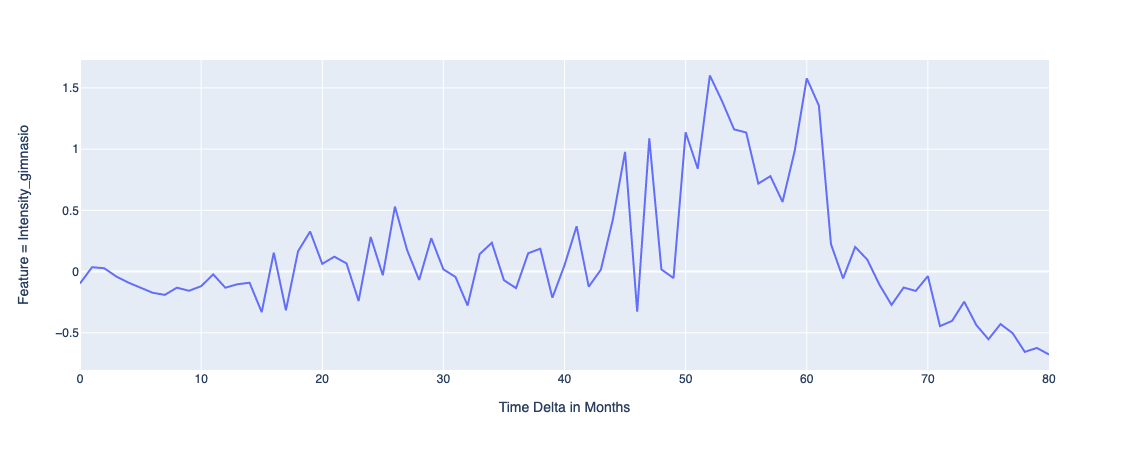

In [30]:
dfn = new_df_scaled(df, target)
y = dfn[target].values
x = np.arange(0,len(dfn))
px.line(x=x, 
        y=y, 
        labels={'x':'Time Delta in Months', 
                'y':f'Feature = {target}'})

In [33]:
# Implement the Kernel
squared_distance = lambda x, y: np.array([[(x[i] - y[j])**2 for i in range(len(x))] for j in range(len(y))])

Text(0, 0.5, 'f(x) = Intensity_gimnasio')

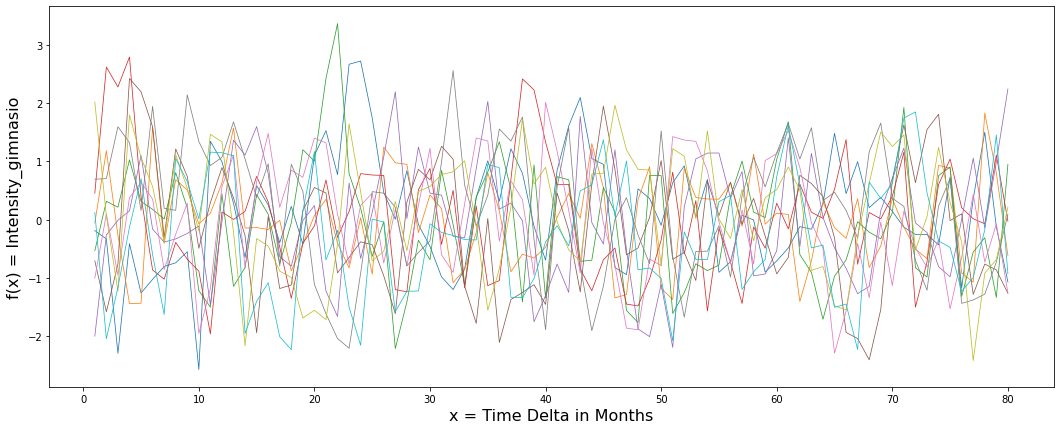

In [35]:
fig = plt.figure(figsize=(18, 7))
np.random.seed(1)
test_points = np.linspace(1, len(x)-1, len(x)-1)
cov = np.exp(-squared_distance(test_points, test_points))
plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=10).T, lw=0.75)
plt.xlabel('x = Time Delta in Months', fontsize=16)
plt.ylabel(f'f(x) = {target}', fontsize=16, rotation=90)

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_multivariate.py:666: RuntimeWarning:

covariance is not positive-semidefinite.

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_multivariate.py:666: RuntimeWarning:

covariance is not positive-semidefinite.

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_multivariate.py:666: RuntimeWarning:

covariance is not positive-semidefinite.

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_multivariate.py:666: RuntimeWarning:

covariance is not positive-semidefinite.

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_multivariate.py:666: RuntimeWarning:

covariance is not positive-semidefinite.

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_multivariate.py:666: RuntimeWarning:

covariance is not positive-semidefinite.

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_multivariate.py:666: RuntimeWarning:

covariance is not positive-

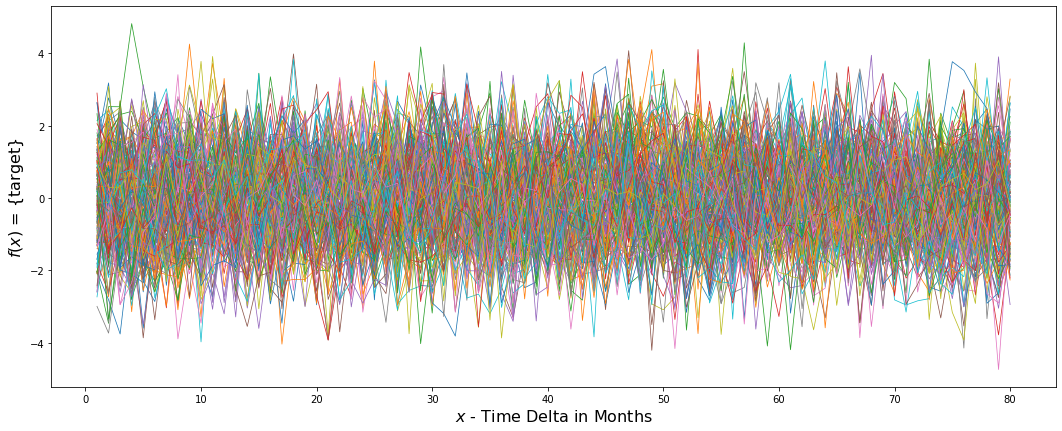

In [37]:
fig = plt.figure(figsize=(18, 7))
np.random.seed(1)
eta = 2 # controls the vertical scale
rho = 0.5 # controls the smothness of the function
sigma = 0.1  # captures the noise in the data

D = squared_distance(test_points, test_points)

cov = eta * np.exp(-rho * D)  # Gaussian radial kernel
diag = eta * sigma  # jitter term to capture the uncertainty around the observed data points

np.fill_diagonal(cov, diag)  # Final Gaussian Kernel

for i in range(20):
    plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=10).T, lw=0.75)
    plt.xlabel('$x$ - Time Delta in Months', fontsize=16)
    plt.ylabel('$f(x)$ = {target}', fontsize=16, rotation=90)

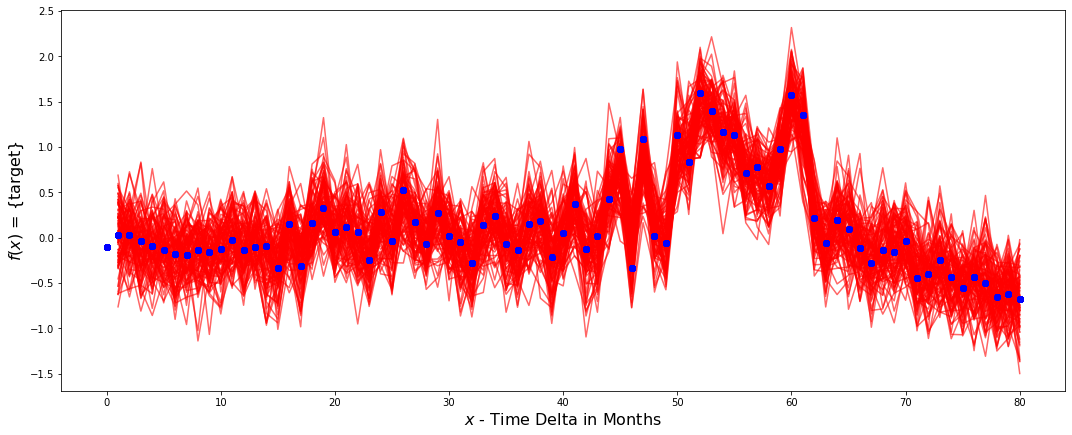

In [38]:
fig = plt.figure(figsize=(18, 7))

np.random.seed(1)

#We define the Kernels: 

# 1. Kernel K for x
D_x = squared_distance(x, x)
K = eta * np.exp(-rho * D_x)
diag_x = eta + sigma
np.fill_diagonal(K, diag_x)

# 2. Kernel K_o for test points
D_off_diag = squared_distance(x, test_points)
K_o = eta * np.exp(-rho * D_off_diag)

# 3. Kernel K_oo for the variance of x_o
K_oo = eta * np.exp(-rho * D) 

# Calculation the mean for the posterior distribution
mu_post = np.dot(np.dot(K_o, np.linalg.inv(K)), y)

# Posterior covariance
SIGMA_post = K_oo - np.dot(np.dot(K_o, np.linalg.inv(K)), K_o.T)

# Plot the posterior 
for i in range(100):
    fx = stats.multivariate_normal.rvs(mean=mu_post, cov=SIGMA_post)
    plt.plot(test_points, fx, 'r-', alpha=0.6)
    plt.plot(x, y, 'bo')
    plt.xlabel('$x$ - Time Delta in Months', fontsize=16)
    plt.ylabel('$f(x)$ = {target}', fontsize=16, rotation=90)

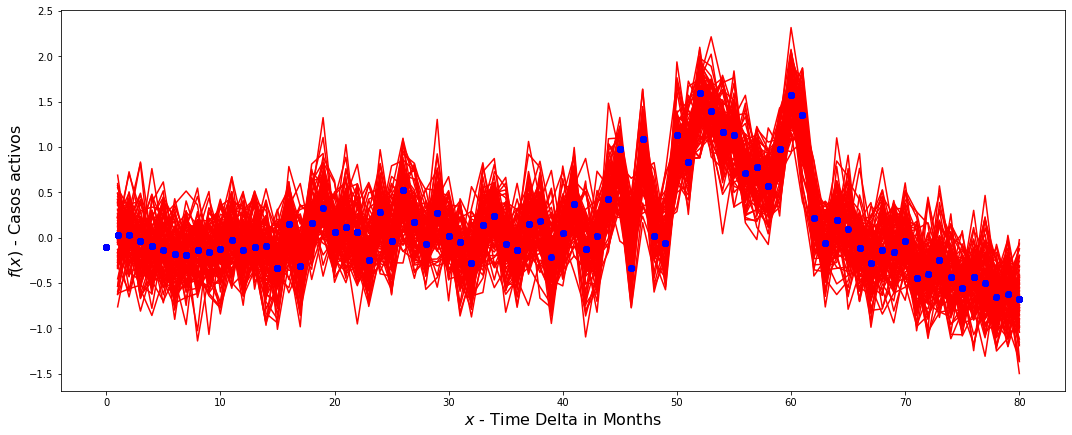

In [39]:
fig = plt.figure(figsize=(18, 7))

np.random.seed(1)

K_oo = eta * np.exp(-rho * D) 
D_x = squared_distance(x, y)

K = eta * np.exp(-rho * D_x)
diag_x = eta * sigma
np.fill_diagonal(K, diag_x)

D_off_diag = squared_distance(x, test_points)
K_o = eta * np.exp(-rho * D_off_diag)

for i in range(100):
    fx = stats.multivariate_normal.rvs(mean=mu_post, cov=SIGMA_post)
    plt.style.context("fivethirtyeight")
    plt.plot(test_points, fx, 'r-', alpha=0.6)
    plt.plot(x, y, 'bo')
    plt.xlabel('$x$ - Time Delta in Months', fontsize=16)
    plt.ylabel('$f(x)$ - Casos activos', fontsize=16, rotation=90)

Text(0, 0.5, '$f(x)$ = Intensity_gimnasio')

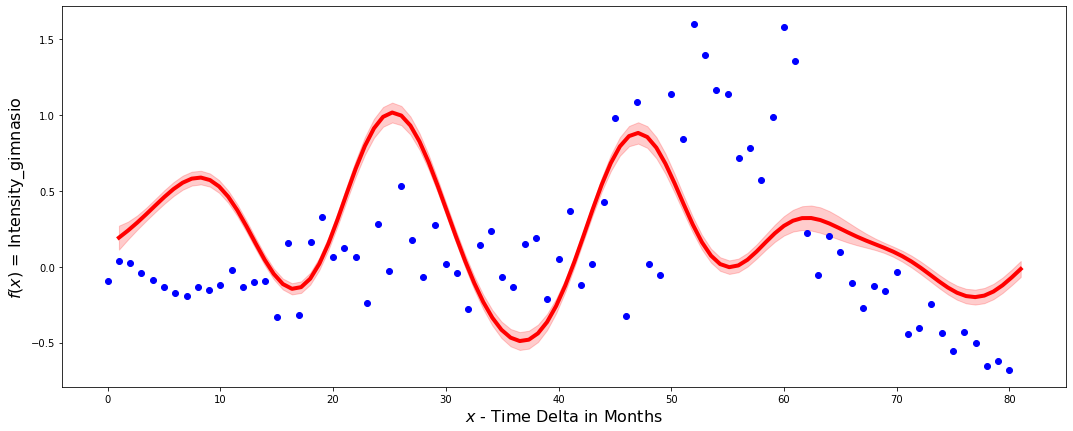

In [42]:
np.random.seed(1)
eta = 0.5 # controls the vertical scale
rho = 0.01  # controls the smothness of the function
sigma = 0.01 #captures the noise in the data

f = lambda x: np.exp(x).flatten()

#define the kernel
def kernel(x, y):
    """ GP squared exponential kernel """
    D = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T)
    return eta * np.exp(- rho * D)

N = len(x)  # number of training points.
n = 50    # number of test points.

# Sample some input points and noisy versions of the function evaluated at these points. 
X = np.random.uniform(1, 100, size=(N,1))
Y = f(X) + sigma * np.random.randn(N)
K = kernel(X, X)
L = np.linalg.cholesky(K + sigma * np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(1, len(x), n).reshape(-1,1)

# compute the mean (mu) at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance (sd_pred) at our test points.
K_ = kernel(Xtest, Xtest)
sd_pred = (np.diag(K_) - np.sum(Lk**2, axis=0))**0.5

#plotted the data as blue dots, the mean function as a red line, and the 
# uncertainty as a semi-transparent red band. The uncertainty 
# is represented as two standard deviations from the mean.

fig = plt.figure(figsize=(18, 7))
plt.fill_between(Xtest.flat, mu-sd_pred, mu+sd_pred, color="r", alpha=0.2)
plt.plot(Xtest, mu, 'r', alpha=1 , lw=4)
plt.plot(x, y, 'bo', alpha=1)
plt.xlabel('$x$ - Time Delta in Months', fontsize=16)
plt.ylabel(f'$f(x)$ = {target}', fontsize=16, rotation=90)

In [43]:
with pm.Model() as GP:
    mu = np.zeros(N)
    eta = pm.HalfCauchy('eta', beta=0.1 )  # controls the vertical scale
    rho = pm.HalfCauchy('rho', beta=0.1)    # controls the smothness of the function
    sigma = pm.HalfCauchy('sigma', beta=0.1)   # captures the noise in the data
    
    # We are going to write the Kernels
    test_points = np.linspace(1, 130, 100)
    
    # 1. 𝐾 is the Kernel for the observed points
    D = squared_distance(x, x) 
    K = tt.fill_diagonal(eta * pm.math.exp(-rho * D), eta + sigma)
    
    obs = pm.MvNormal('obs', mu, cov=K, observed=y)
    
    # 2. 𝐾_∗∗ is the covariance of 𝑥_∗
    
    D_pred = squared_distance(test_points, test_points)
    K_oo = eta * pm.math.exp(-rho * D_pred)
    
    # 3. 𝐾_∗ is the Kernel for the test points
    D_off_diag = squared_distance(x, test_points)
    K_o = eta * pm.math.exp(-rho * D_off_diag)
    
    mu_post = pm.Deterministic('mu_post', pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), y))
    SIGMA_post = pm.Deterministic('SIGMA_post', K_oo - pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), K_o.T))
    
    trace = pm.sample(2000, step=pm.Metropolis())

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [rho]
>Metropolis: [eta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 121 seconds.
The number of effective samples is smaller than 25% for some parameters.


/Applications/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'rho'}>,
        <AxesSubplot:title={'center':'rho'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

<Figure size 432x288 with 0 Axes>

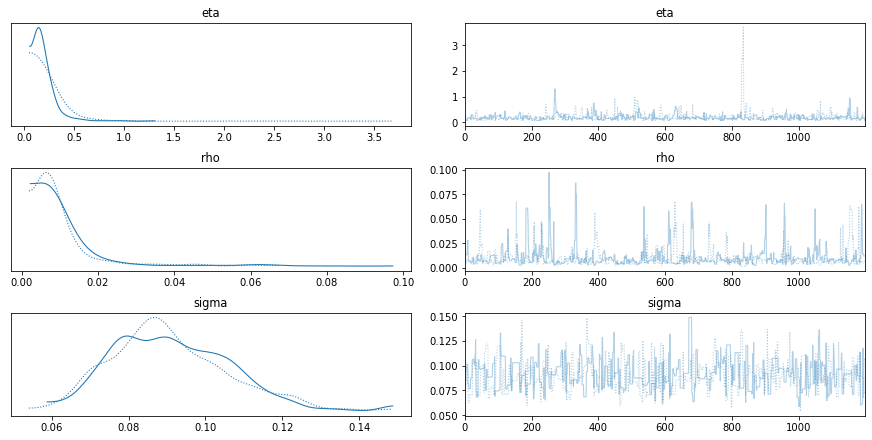

In [44]:
fig = plt.figure()
varnames = ['eta', 'rho', 'sigma']
chain = trace[800:]
pm.traceplot(chain, varnames)

In [45]:
# R_hat (Gelman-Rubin test): Ideally should expect a value R = 1 or, at least, R < 1.0 and < 1.1
pm.summary(chain, varnames).round(5)

/Applications/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
eta,0.205,0.177,0.068,0.400,0.010,0.007,309.0,309.0,331.0,411.0,1.0
rho,0.011,0.010,0.002,0.024,0.001,0.000,368.0,368.0,332.0,448.0,1.0
sigma,0.091,0.015,0.068,0.121,0.001,0.001,455.0,446.0,470.0,416.0,1.0


/Applications/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

/Applications/anaconda3/lib/python3.7/site-packages/arviz/plots/plot_utils.py:563: UserWarning:

rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (20206) in plot_autocorr, generating only 40 plots



array([[<AxesSubplot:title={'center':'eta\n0'}>,
        <AxesSubplot:title={'center':'eta\n1'}>,
        <AxesSubplot:title={'center':'rho\n0'}>,
        <AxesSubplot:title={'center':'rho\n1'}>,
        <AxesSubplot:title={'center':'sigma\n0'}>,
        <AxesSubplot:title={'center':'sigma\n1'}>,
        <AxesSubplot:title={'center':'mu_post\n0, 0'}>,
        <AxesSubplot:title={'center':'mu_post\n0, 1'}>,
        <AxesSubplot:title={'center':'mu_post\n0, 2'}>,
        <AxesSubplot:title={'center':'mu_post\n0, 3'}>,
        <AxesSubplot:title={'center':'mu_post\n0, 4'}>,
        <AxesSubplot:title={'center':'mu_post\n0, 5'}>,
        <AxesSubplot:title={'center':'mu_post\n0, 6'}>,
        <AxesSubplot:title={'center':'mu_post\n0, 7'}>,
        <AxesSubplot:title={'center':'mu_post\n0, 8'}>,
        <AxesSubplot:title={'center':'mu_post\n0, 9'}>,
        <AxesSubplot:title={'center':'mu_post\n0, 10'}>,
        <AxesSubplot:title={'center':'mu_post\n0, 11'}>,
        <AxesSubplot:title={

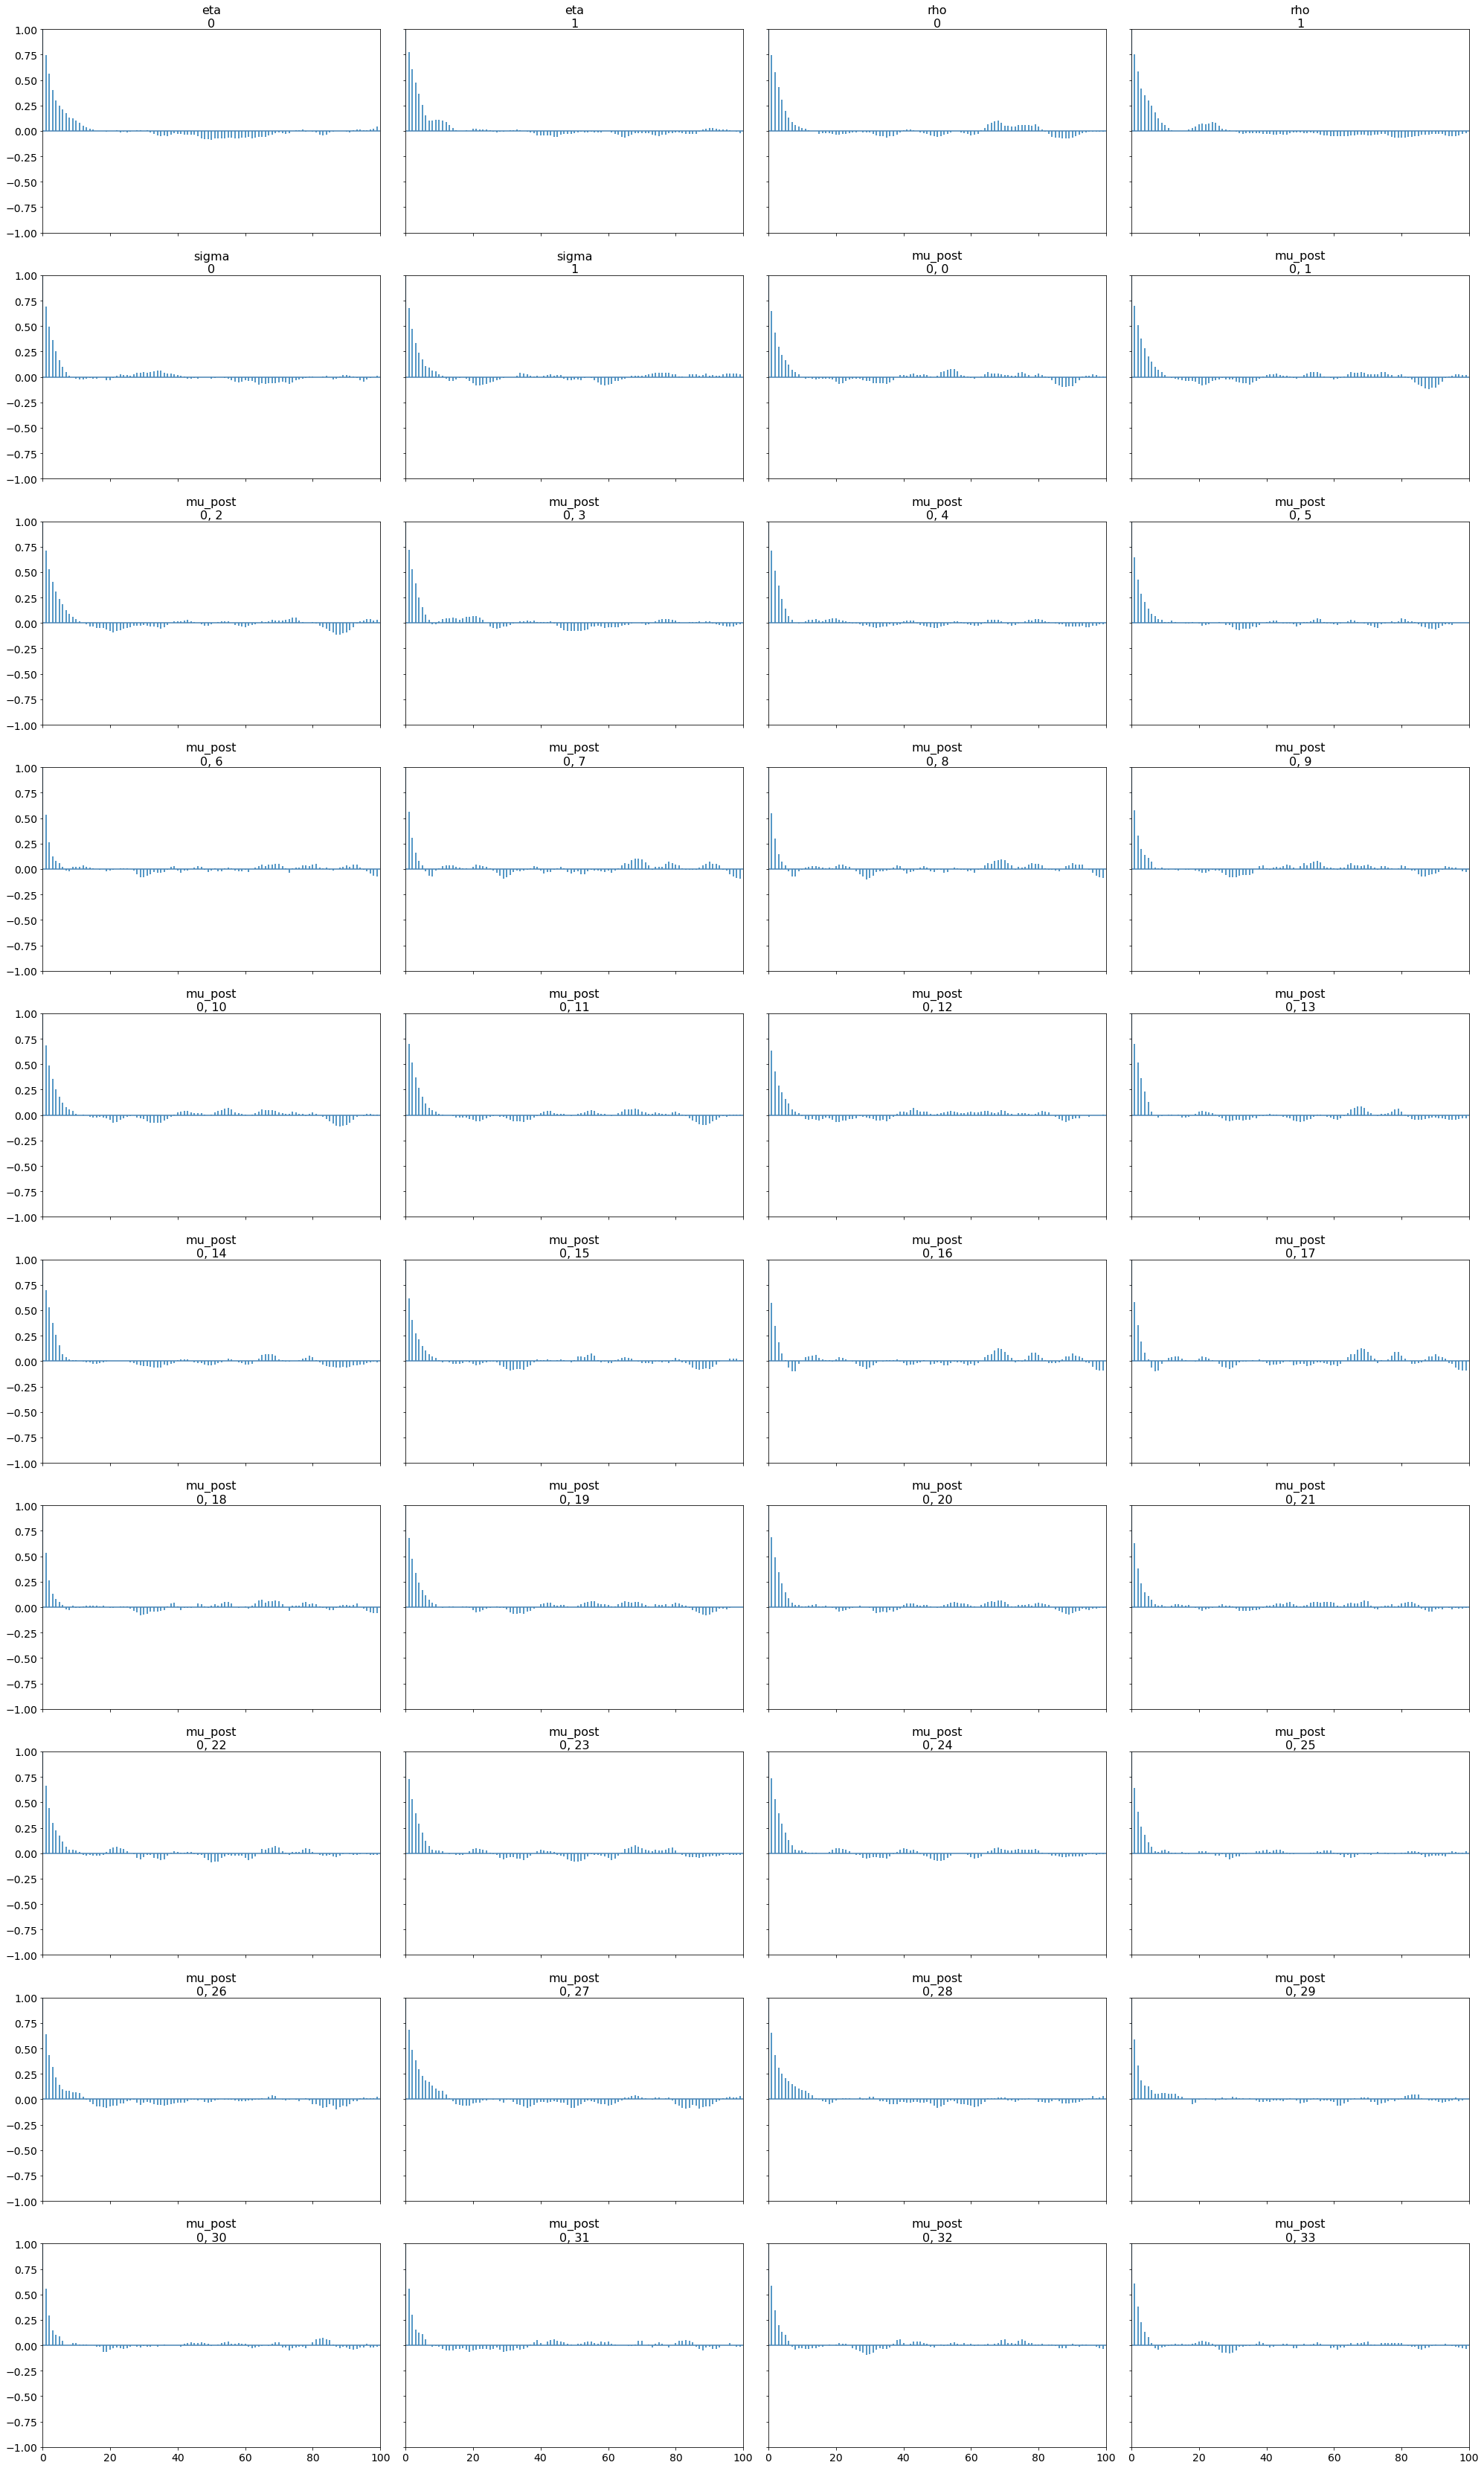

In [46]:
pm.autocorrplot(trace[:2000])

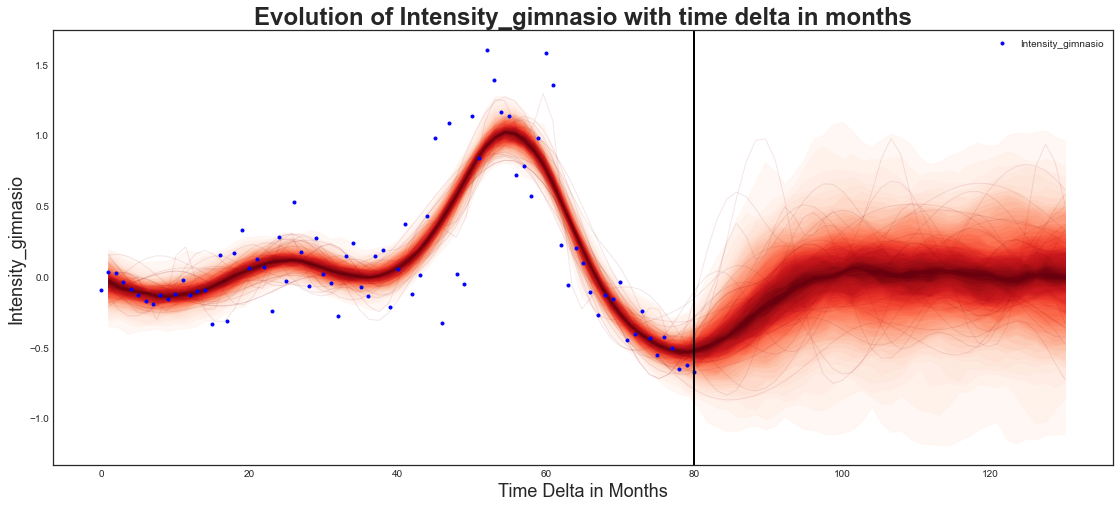

In [60]:
today = date.today()
y_pred = [np.random.multivariate_normal (m, S) for m, S in zip(chain['mu_post'][::10], chain['SIGMA_post'][::10])]
mean_y_pred = np.mean((y_pred), axis=0) 
standard = np.std((y_pred), axis=0)

with plt.style.context("seaborn-white"):
    fig = plt.figure(figsize=(19,8)); 
    ax = fig.gca()
    plt.title(f'Evolution of {target} with time delta in months', fontweight=600, fontsize=24 )
    plot_gp_dist(ax, np.asarray(y_pred), test_points, 'b');
    plt.plot(x, np.asarray(y), '.', color='blue', lw=3, label=f'{target}')
    plt.axvline(x= len(x)-1, ymin=0, ymax=max(mean_y_pred) +10000, color='black', lw=2)
    plt.xlabel('Time Delta in Months', fontsize=18)
    plt.ylabel(f'{target}', fontsize=18, rotation=90)
    plt.legend()
    plt.savefig('/Users/javiermarin/desktop/Test2_3.png')
    plt.show()

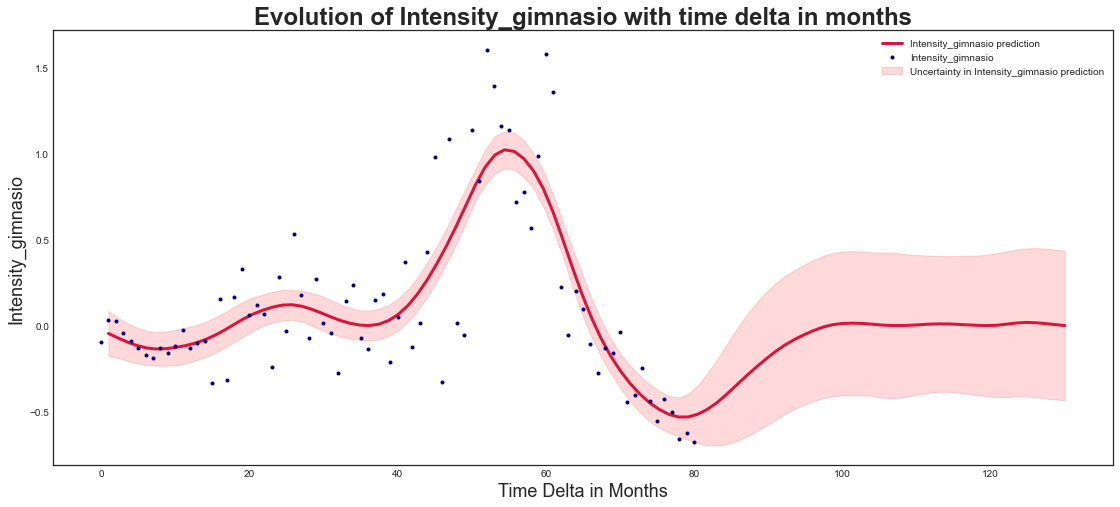

In [61]:
with plt.style.context("seaborn-white"):
    
    fig = plt.figure(figsize=(19,8))
    plt.title(f'Evolution of {target} with time delta in months', fontweight=600, fontsize=24 )
    plt.plot(test_points , mean_y_pred , color='crimson', lw=3, label=f'{target} prediction') 
    plt.fill_between(test_points, mean_y_pred -standard, mean_y_pred + standard, color="r", 
                    alpha=0.15, label=f'Uncertainty in {target} prediction')
    plt.plot(x, y,'.', color='navy', lw=2, label= f'{target}')
    #plt.axvline(x= len(x)-1, ymin=0, ymax=max(mean_y_pred) +10000 , color='grey', lw=2)
    #plt.annotate(today, xy=(len(x)-1, 110000), arrowprops=dict(arrowstyle='simple'), xytext=(30, 110000))
    plt.xlabel('Time Delta in Months', fontsize=18)
    plt.ylabel(f'{target}', fontsize=18, rotation=90)
    plt.legend()
    plt.show()

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



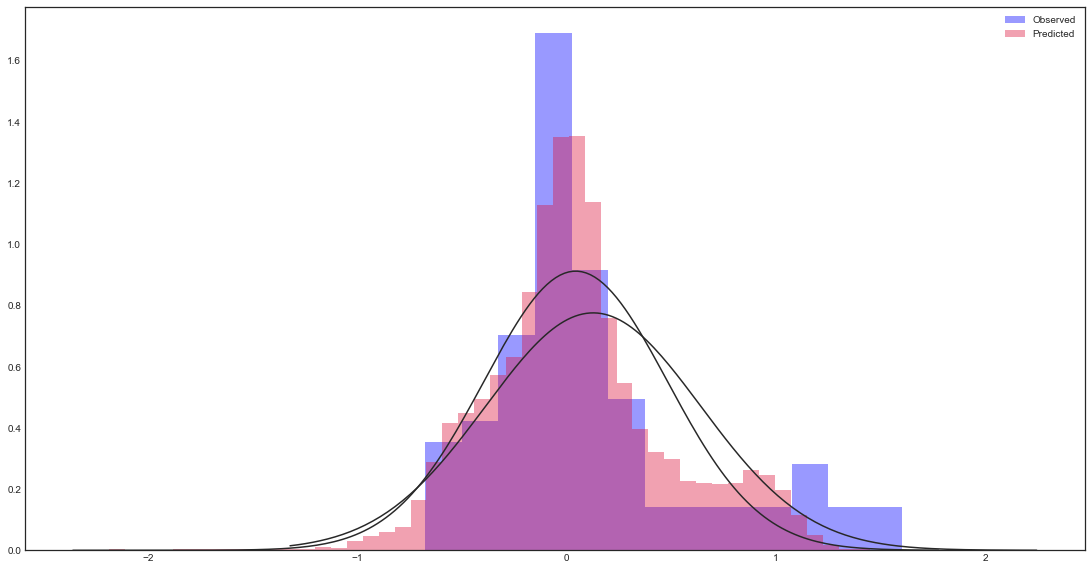

In [57]:
## We now compare the original data distributions with predicted's data one.
import seaborn as sns
from scipy.stats import norm
with plt.style.context("seaborn-white"):
    fig = plt.figure(figsize=(19,10))
    sns.distplot(y, fit=norm, kde=False, color="blue", label='Observed')
    sns.distplot(y_pred, fit=norm, kde=False, color="crimson", label='Predicted')
    plt.legend()
    plt